In [0]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import timedelta

from scipy.optimize import curve_fit,minimize
import scipy.integrate
from scipy import stats

from sklearn.metrics import mean_squared_error,mean_absolute_error

import numpy 



# Prepare dataset

Dataset are taken from [here](https://github.com/datasets/covid-19) which converted wide-formatted data provided by [Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE)](https://github.com/CSSEGISandData/COVID-19) to long-formatted.

In [0]:

data_url= 'https://github.com/datasets/covid-19/blob/master/data/countries-aggregated.csv'
req=requests.get(data_url)
case_report_by_country = pd.read_html(req.content)[0]
case_report_by_country = case_report_by_country[['Date','Country','Confirmed','Deaths']]
case_report_by_country['converted_date'] = pd.to_datetime(case_report_by_country['Date'])
case_report_by_country.head()


,Date,Country,Confirmed,Deaths,converted_date
0,2020-01-22,Afghanistan,0,0,2020-01-22
1,2020-01-22,Albania,0,0,2020-01-22
2,2020-01-22,Algeria,0,0,2020-01-22
3,2020-01-22,Andorra,0,0,2020-01-22
4,2020-01-22,Angola,0,0,2020-01-22


## First N days


In [0]:
case_report_by_counry_from_day1 = case_report_by_country[case_report_by_country['Confirmed']>0] #remove country with Confirmed=0
case_report_by_counry_from_day1["day"] = case_report_by_counry_from_day1.groupby(["Country"])["converted_date"].rank(ascending=True)
case_report_by_counry_from_day1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Country,Confirmed,Deaths,converted_date,day
36,2020-01-22,China,548,17,2020-01-22,1.0
86,2020-01-22,Japan,2,0,2020-01-22,1.0
90,2020-01-22,"Korea, South",1,0,2020-01-22,1.0
163,2020-01-22,Taiwan*,1,0,2020-01-22,1.0
165,2020-01-22,Thailand,2,0,2020-01-22,1.0


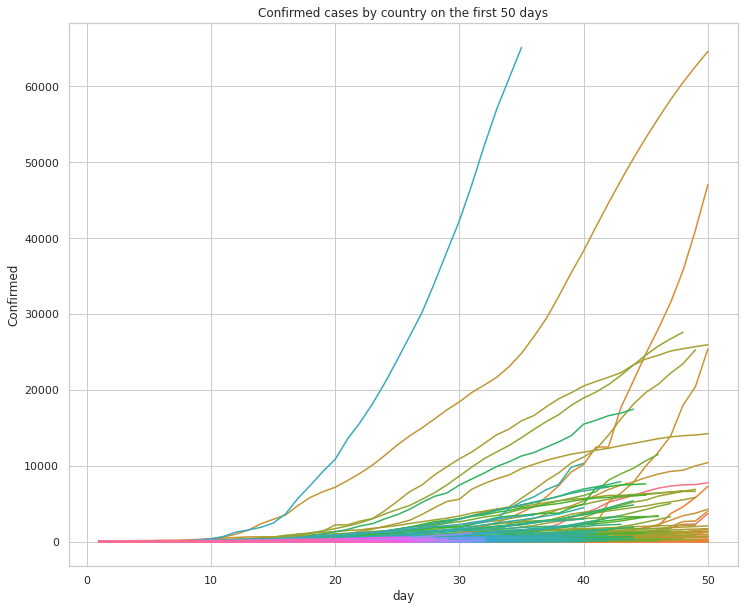

In [0]:
n = 50
first_n_day = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['day']<=n)&(case_report_by_counry_from_day1['Country']!='China')]
plt.figure(figsize=(12, 10))
ax = sns.lineplot(x="day",y="Confirmed",hue="Country",data=first_n_day)
ax.set_title("Confirmed cases by country on the first "+ str(n)+" days")
ax.get_legend().set_visible(False)
plt.show()

## Cumulative cases

#### Thailand

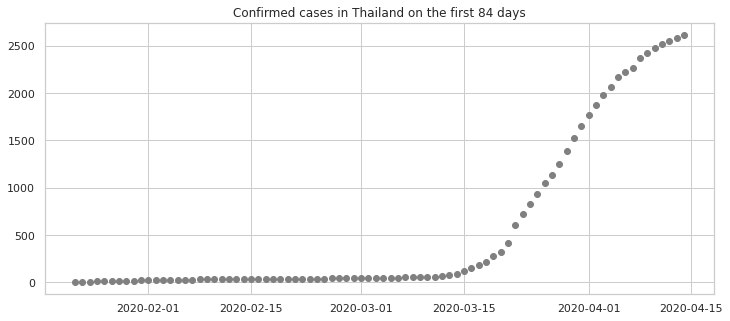

In [0]:
n = 100
country_list = ['Thailand']
first_n_day = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['day']<=n)&(case_report_by_counry_from_day1['Country'].isin(country_list))]
n = int(np.max(first_n_day['day']))
plt.figure(figsize=(12, 5))
plt.scatter(first_n_day['converted_date'],first_n_day['Confirmed'],label="actual confirmed",color="grey")
plt.title("Confirmed cases in Thailand on the first "+ str(n)+" days")
plt.show()

#### China

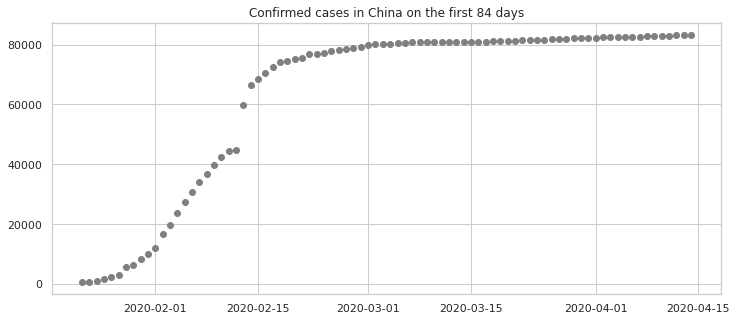

In [0]:
n = 100
country_list = ['China']
first_n_day = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['day']<=n)&(case_report_by_counry_from_day1['Country'].isin(country_list))]
n = int(np.max(first_n_day['day']))
plt.figure(figsize=(12, 5))
plt.scatter(first_n_day['converted_date'],first_n_day['Confirmed'],label="actual confirmed",color="grey")
plt.title("Confirmed cases in China on the first "+ str(n)+" days")
plt.show()

#### South Korea

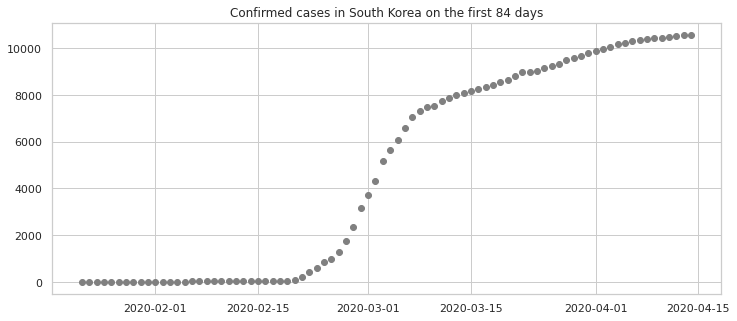

In [0]:
n = 100
country_list = ['Korea, South']
first_n_day = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['day']<=n)&(case_report_by_counry_from_day1['Country'].isin(country_list))]
n = int(np.max(first_n_day['day']))
plt.figure(figsize=(12, 5))
plt.scatter(first_n_day['converted_date'],first_n_day['Confirmed'],label="actual confirmed",color="grey")
plt.title("Confirmed cases in South Korea on the first "+ str(n)+" days")
plt.show()

## New cases

In [0]:
new_case_report_by_country = case_report_by_counry_from_day1.copy()
new_case_report_by_country['yesterday'] = new_case_report_by_country['day']-1
new_case_report_by_country = new_case_report_by_country.merge(right = new_case_report_by_country,left_on = ['Country','yesterday'],right_on=['Country','day'])
new_case_report_by_country['new_confirmed'] = new_case_report_by_country['Confirmed_x'] - new_case_report_by_country['Confirmed_y']
new_case_report_by_country['new_deaths'] = new_case_report_by_country['Deaths_x'] - new_case_report_by_country['Deaths_y']
new_case_report_by_country = new_case_report_by_country[['Date_x','Country','new_confirmed','new_deaths','converted_date_x','day_x']].copy()
new_case_report_by_country.columns=['Date','Country','new_confirmed','new_deaths','converted_date','day']
new_case_report_by_country.head()

,Date,Country,new_confirmed,new_deaths,converted_date,day
0,2020-01-23,China,95,1,2020-01-23,2.0
1,2020-01-23,Japan,0,0,2020-01-23,2.0
2,2020-01-23,"Korea, South",0,0,2020-01-23,2.0
3,2020-01-23,Taiwan*,0,0,2020-01-23,2.0
4,2020-01-23,Thailand,1,0,2020-01-23,2.0


#### Thailand

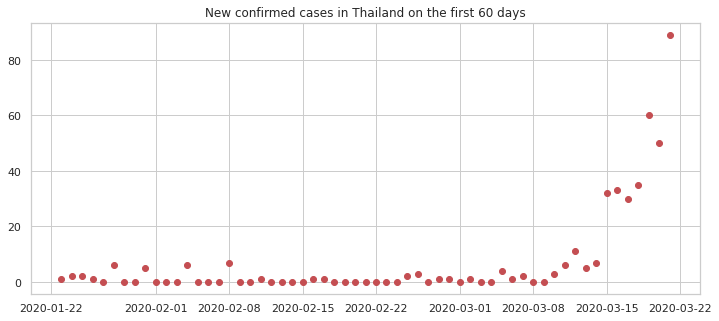

In [0]:
n = 60
country_list = ['Thailand']
new_case_by_selected_country = new_case_report_by_country[(new_case_report_by_country['day']<=n)&(new_case_report_by_country['Country'].isin(country_list))]
n = int(np.max(new_case_by_selected_country['day']))
plt.figure(figsize=(12, 5))
plt.scatter(new_case_by_selected_country['converted_date'],new_case_by_selected_country['new_confirmed'],label="New confirmed cases",color="r")
plt.title("New confirmed cases in Thailand on the first "+ str(n)+" days")
plt.show()

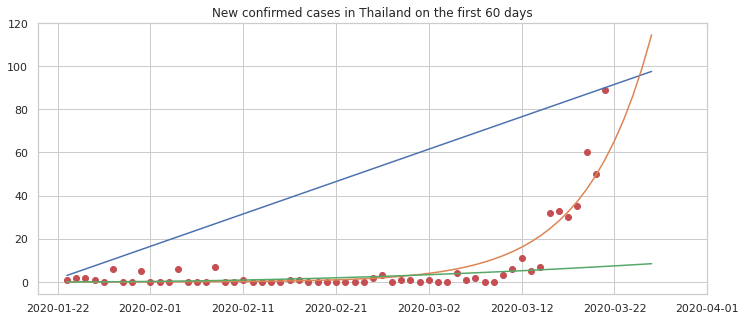

In [0]:
import datetime
n = 60
x = np.arange(2,n+6)
y1 = 1.5*x
y2 = 0.006 * np.exp(0.14*(x+5.4))
y3 = 0.002 * x**2
country_list = ['Thailand']
new_case_by_selected_country = new_case_report_by_country[(new_case_report_by_country['day']<=n)&(new_case_report_by_country['Country'].isin(country_list))]
n = int(np.max(new_case_by_selected_country['day']))
plt.figure(figsize=(12, 5))
plt.scatter(new_case_by_selected_country['day'],new_case_by_selected_country['new_confirmed'],label="New confirmed cases",color="r")
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.xticks(np.arange(1,n+20,10), [(datetime.date(2020, 1, 21)+datetime.timedelta(days=i)) for i in range(1,n+20,10)])
plt.title("New confirmed cases in Thailand on the first "+ str(n)+" days")
plt.show()

#### China

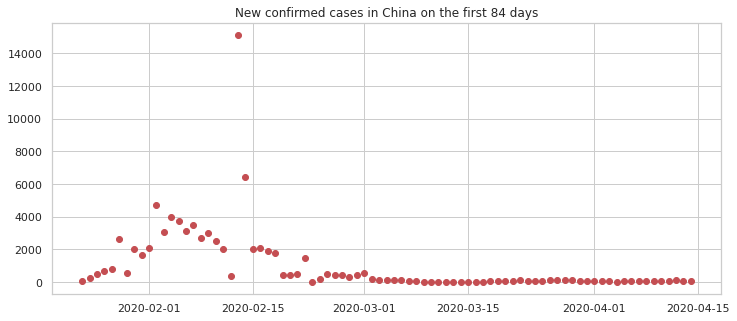

In [0]:
n = 120
country_list = ['China']
new_case_by_selected_country = new_case_report_by_country[(new_case_report_by_country['day']<=n)&(new_case_report_by_country['Country'].isin(country_list))]
n = int(np.max(new_case_by_selected_country['day']))
plt.figure(figsize=(12, 5))
plt.scatter(new_case_by_selected_country['converted_date'],new_case_by_selected_country['new_confirmed'],label="New confirmed cases",color="r")
plt.title("New confirmed cases in China on the first "+ str(n)+" days")
plt.show()

#### Italy

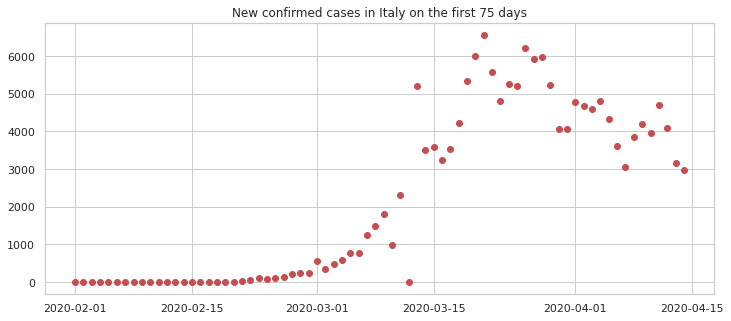

In [0]:
n = 120
country_list = ['Italy']
new_case_by_selected_country = new_case_report_by_country[(new_case_report_by_country['day']<=n)&(new_case_report_by_country['Country'].isin(country_list))]
n = int(np.max(new_case_by_selected_country['day']))
plt.figure(figsize=(12, 5))
plt.scatter(new_case_by_selected_country['converted_date'],new_case_by_selected_country['new_confirmed'],label="New confirmed cases",color="r")
plt.title("New confirmed cases in Italy on the first "+ str(n)+" days")
plt.show()

#### South Korea

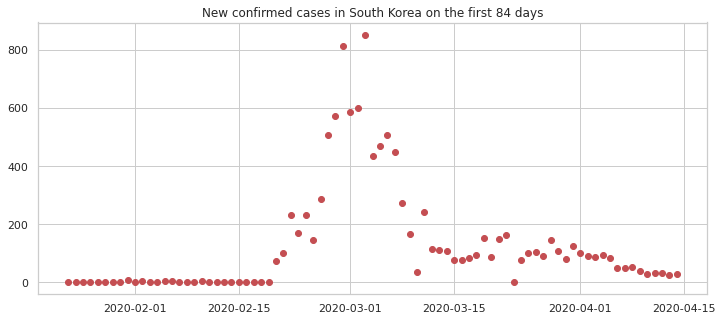

In [0]:
n = 120
country_list = ['Korea, South']
new_case_by_selected_country = new_case_report_by_country[(new_case_report_by_country['day']<=n)&(new_case_report_by_country['Country'].isin(country_list))]
n = int(np.max(new_case_by_selected_country['day']))
plt.figure(figsize=(12, 5))
plt.scatter(new_case_by_selected_country['converted_date'],new_case_by_selected_country['new_confirmed'],label="New confirmed cases",color="r")
plt.title("New confirmed cases in South Korea on the first "+ str(n)+" days")
plt.show()

# Exponential growth


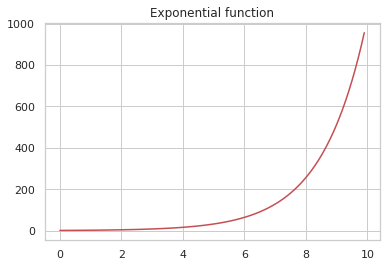

In [0]:
x = np.arange(0,10,0.1)
y = 2**x
plt.plot(x,y,'r')
plt.title('Exponential function')
plt.show()

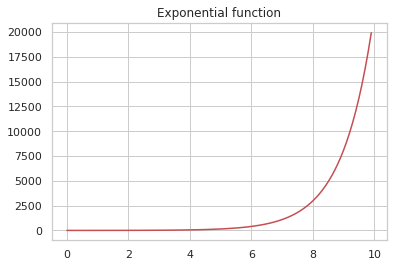

In [0]:
x = np.arange(0,10,0.1)
y = np.exp(x)
plt.plot(x,y,'r')
plt.title('Exponential function')
plt.show()

In [0]:
def exponential_model(x,a,b,c):
  return a*np.exp(b*(x-c))

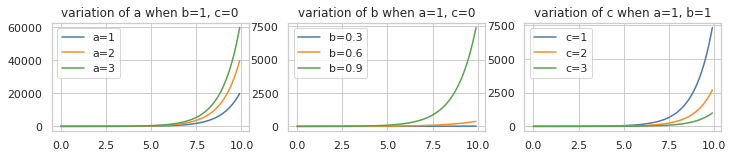

In [0]:
x = np.arange(0,10,0.1)
a_var = np.arange(1,4,1)
b_var = np.arange(0.3,1.1,0.3)
c_var = np.arange(1,4,1)

#a determines the amplitude 
color_list = ['#4E79A7','#F28E2B','#59A14F']
i=0
fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharex=True,figsize=(12,2))
for a in a_var:
  y = exponential_model(x,a=a,b=1,c=0)
  ax1.plot(x,y,color_list[i],label = 'a='+str(a))
  i+=1
ax1.set_title('variation of a when b=1, c=0')
ax1.legend(loc="upper left")

#b determines growth rate
i=0
for b in b_var:
  y = exponential_model(x,a=1,b=b,c=0)
  ax2.plot(x,y,color_list[i],label = 'b='+str(round(b,1)))
  i+=1
ax2.set_title('variation of b when a=1, c=0')
ax2.legend(loc="upper left")

#c shifts curve left or right
i=0
for c in c_var:
  y = exponential_model(x,a=1,b=1,c=c)
  ax3.plot(x,y,color_list[i],label = 'c='+str(c))
  i += 1
ax3.set_title('variation of c when a=1, b=1')
ax3.legend(loc="upper left")
plt.show()

## Fit with least squared estimation


### Thailand


In [0]:
n_train = 60
n_predict = 70
country='Thailand'
country_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['Country']==country)]
x= country_cases['day'].to_numpy()
y= country_cases['Confirmed'].to_numpy()
x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:n_predict]
y_test = y[n_train:n_predict]

In [0]:
  exp_fit = curve_fit(exponential_model,x_train,y_train,p0=[0.1,-0.1,0.1])
  a_pred = exp_fit[0][0]
  b_pred = exp_fit[0][1]
  c_pred = exp_fit[0][2]
  print('a_pred = ' + str(a_pred))
  print('b_pred = ' + str(b_pred))
  print('c_pred = ' + str(c_pred))
  x_pred = np.arange(1,n_predict+1)
  y_pred = exponential_model(x_pred,a=a_pred,b=b_pred,c=c_pred)

a_pred = 0.07584587236524387
b_pred = 0.16829746712913493
c_pred = 9.428545351739222


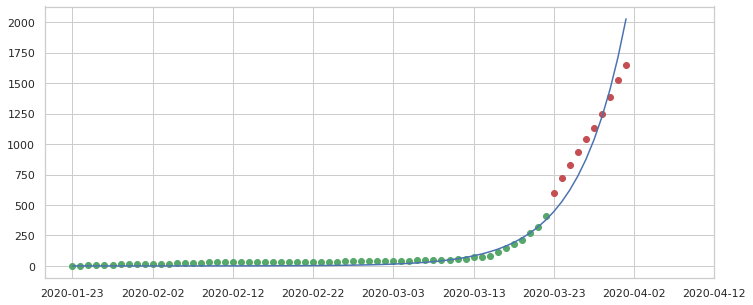

In [0]:
  plt.figure(figsize=(12, 5))
  plt.scatter(x_train,y_train,label="actual confirmed",color="g")
  plt.scatter(x_test,y_test,label="actual confirmed",color="r")
  plt.plot(x_pred, y_pred, label="Exponential model of " + country )
  plt.xticks(np.arange(1,n_predict+15,10), [(datetime.date(2020, 1, 22)+datetime.timedelta(days=i)) for i in range(1,n_predict+15,10)])
  plt.show()

In [0]:
mean_absolute_error(y_train, y_pred[:n_train])

21.938669157761545

In [0]:
mean_absolute_error(y_test, y_pred[n_train:n_train+len(y_test)])

166.48131019291998

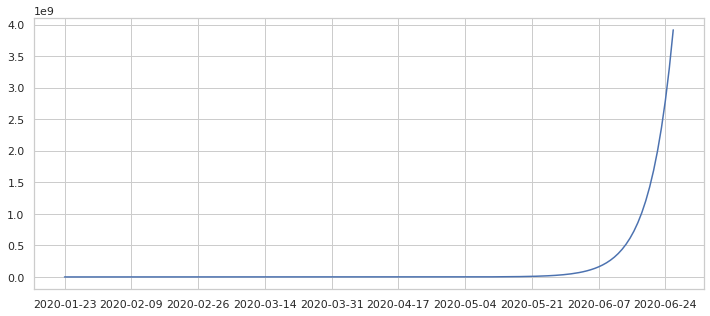

In [0]:
x = np.arange(1,157)
y_pred = exponential_model(x,a=a_pred,b=b_pred,c=c_pred)
plt.figure(figsize=(12, 5))
plt.plot(x, y_pred, label="Exponential model" )
plt.xticks(np.arange(1,157,17), [(datetime.date(2020, 1, 22)+datetime.timedelta(days=i)) for i in range(1,157,17)])
plt.show()

### Write a function for reusability

In [0]:
def exponential_model_least_square_plot(country,n_train,n_predict,initial_param=[1,1,-1]):
  country_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['Country']==country)]
  x= country_cases['day'].to_numpy()
  y= country_cases['Confirmed'].to_numpy()
  x_train = x[:n_train]
  y_train = y[:n_train]
  min_date = np.min(country_cases['converted_date']).date()
  x_test = x[n_train:n_predict]
  y_test = y[n_train:n_predict]

  
  exp_fit = curve_fit(exponential_model,x_train,y_train,p0=initial_param)
  a_pred = exp_fit[0][0]
  b_pred = exp_fit[0][1]
  c_pred = exp_fit[0][2]
  print('a_pred = ' + str(a_pred))
  print('b_pred = ' + str(b_pred))
  print('c_pred = ' + str(c_pred))
  x_pred = np.arange(1,n_predict+1)
  y_pred = exponential_model(x_pred,a=a_pred,b=b_pred,c=c_pred)

  print('MAE (training set) = '+ str(mean_absolute_error(y_train, y_pred[:min(len(x_train),n_train)])))
  if len(y_test) > 0:
    print('MAE (test set) = '+ str(mean_absolute_error(y_test, y_pred[n_train:n_train+len(y_test)])))

  plt.figure(figsize=(12, 5))
  plt.scatter(x_train,y_train,label="actual confirmed",color="g")
  plt.scatter(x_test,y_test,label="actual confirmed",color="r")
  plt.plot(x_pred, y_pred)
  plt.xticks(np.arange(1,n_predict+15,10), [(min_date+datetime.timedelta(days=i-1)) for i in range(1,n_predict+15,10)])
  plt.title("Exponential model of " + country )
  plt.show()

a_pred = 0.013405323031150785
b_pred = 0.16830423451189766
c_pred = -0.86661933535734
MAE (training set) = 21.93849313462637
MAE (test set) = 166.49578072684648


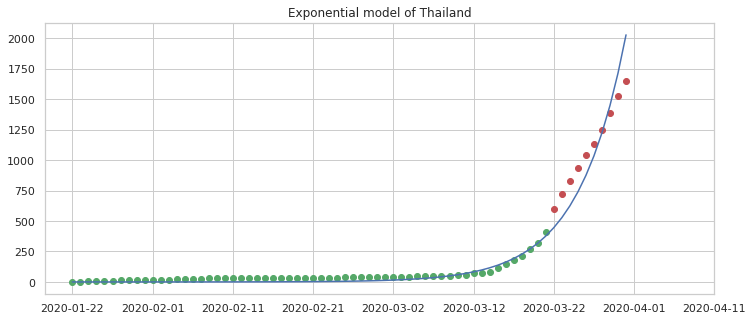

In [0]:
exponential_model_least_square_plot(country='Thailand',n_train=60,n_predict = 70)

#### Italy

a_pred = 3.6092717996339747
b_pred = 0.1550507430917281
c_pred = -11.347753801767654
MAE (training set) = 615.3986855349573
MAE (test set) = 258743.3280969425


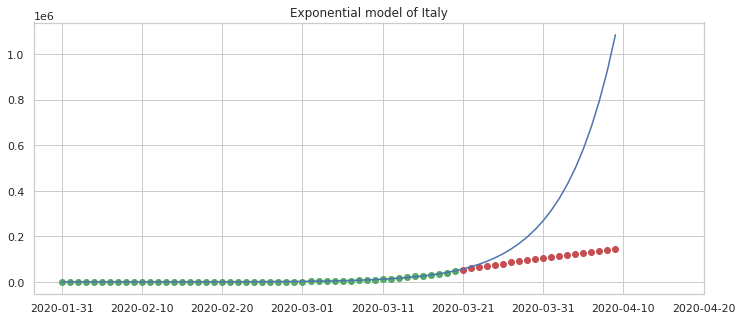

In [0]:
exponential_model_least_square_plot(country='Italy',n_train=50,n_predict = 70)

#### South Korea

a_pred = 0.06302045623278638
b_pred = 0.27560434575485104
c_pred = -0.04469694435291592
MAE (training set) = 39.28218090453136
MAE (test set) = 17450.61400530933


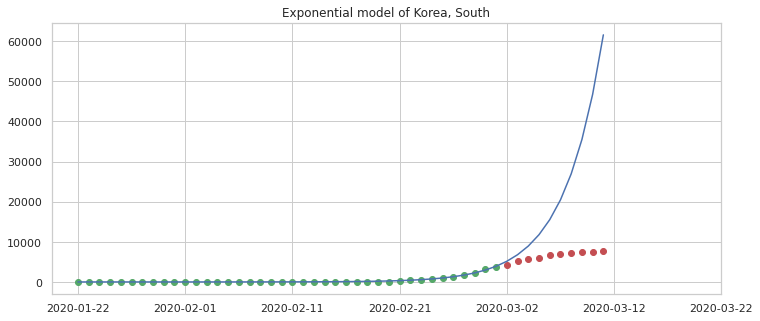

In [0]:
exponential_model_least_square_plot(country='Korea, South',n_train=40,n_predict = 50)

#### Japan

a_pred = 4.8895784201472186
b_pred = 0.09398420718263376
c_pred = -1.9735131360016167
MAE (training set) = 9.332891862161755
MAE (test set) = 830.2399826251564


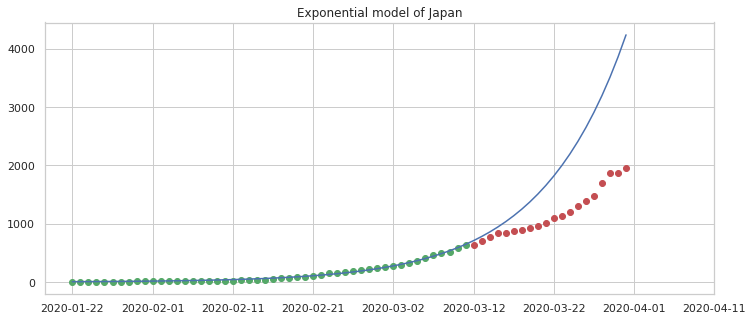

In [0]:
exponential_model_least_square_plot(country='Japan',n_train=50,n_predict = 70)

#### China

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


a_pred = 241.77016121817277
b_pred = 0.049216650327906473
c_pred = -82.66178568441978
MAE (training set) = 10986.014949065931
MAE (test set) = 95760.99980531454


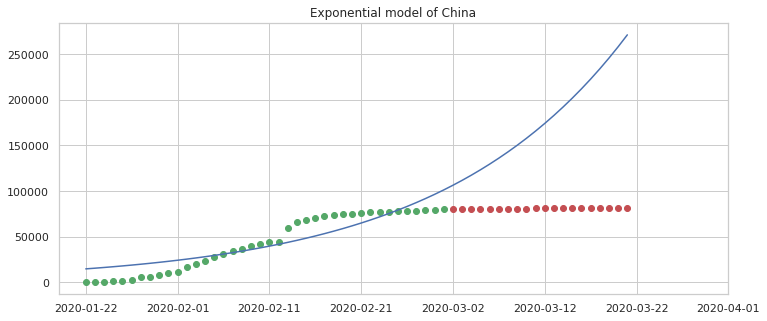

In [0]:
exponential_model_least_square_plot(country='China',n_train=40,n_predict = 60,initial_param=(4,0,-1))

## Fit with maximum likelihood estimation 
source code modified 
from [stackexchange](https://stats.stackexchange.com/questions/66199/maximum-likelihood-curve-model-fitting-in-python) 

Uncertainty from [stackexchange](https://stats.stackexchange.com/questions/424073/calculate-the-uncertainty-of-a-mle)

In [0]:
import numpy.linalg as lin
import autograd.numpy as np 
from autograd import grad, jacobian, hessian
from scipy.optimize import minimize

A = np.array([950])
src = np.array([14,8])
det = np.array([np.arange(5,20),np.arange(5,20)])
meas  = np.array((A/(np.square(src[0] - det[0,:])+np.square(src[1] - det[1,:]))))

def log_likelihood(params):
  b = np.array([(params[0] / (np.square(params[1]- det[0,:]) + np.square(params[2] - det[1,:])))])
  L = np.array(np.sum(b - np.multiply(meas, np.log(b))))
  return L

x0 = np.array([800,11,5])
jacobian_ = jacobian(log_likelihood)
hessian_ = hessian(log_likelihood)

MLE = minimize(log_likelihood,x0,method='Nelder-Mead')
var = lin.inv(hessian_(MLE.x))
var

array([[ 1.54209638e+04,  2.99724443e+01, -3.35481187e+01],
       [ 2.99724443e+01,  1.10376343e-01, -3.75910430e-02],
       [-3.35481187e+01, -3.75910430e-02,  1.24486613e-01]])

### Write a function

In [0]:
def exponential_model_mle_plot_frequency(country,n_train,n_predict,initial_param=[1,1,-1],distribution='gaussian',show_test_set = True):
  new_case_by_selected_country = new_case_report_by_country[new_case_report_by_country['Country']==country]
  x = new_case_by_selected_country['day'].to_numpy()
  y= new_case_by_selected_country['new_confirmed'].to_numpy()
  x_train = x[:n_train]
  y_train = y[:n_train]
  min_date = np.min(new_case_by_selected_country['converted_date']).date()
  x_test = x[n_train:n_predict]
  y_test = y[n_train:n_predict]

  country_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['Country']==country)]
  x= country_cases['day'].to_numpy()
  y= country_cases['Confirmed'].to_numpy()
  x_accum = x[:n_predict]

  x_accum_train = x[:n_train+1]
  y_accum_train = y[:n_train+1]
  x_accum_test = x[n_train+1:n_predict+1]
  y_accum_test = y[n_train+1:n_predict+1]

  def sum_negative_log_likelihood_gaussian(params):
    a,b,c,sd = params
    y = exponential_model(x_train,a,b,c)
    neg_log_likelihood = -np.sum( stats.norm.logpdf(y_train, loc=y, scale=sd ) )
    return (neg_log_likelihood)

  def sum_negative_log_likelihood_poisson(params):
    a,b,c = params
    y = exponential_model(x_train,a,b,c)
    neg_log_likelihood = -np.sum(stats.poisson.logpmf(y_train, mu=y))
    return (neg_log_likelihood)
  if distribution == 'gaussian':
    exp_fit = minimize(sum_negative_log_likelihood_gaussian, initial_param, method='Nelder-Mead')
  else:
    exp_fit = minimize(sum_negative_log_likelihood_poisson, initial_param, method='Nelder-Mead')
    
  a_pred = exp_fit.x[0]
  b_pred = exp_fit.x[1]
  c_pred = exp_fit.x[2]
  print('a_pred = ' + str(a_pred))
  print('b_pred = ' + str(b_pred))
  print('c_pred = ' + str(c_pred))
  x_pred = np.arange(2,n_predict+2)
  y_pred = exponential_model(x_pred,a=a_pred,b=b_pred,c=c_pred)
  y_pred_accum = y_pred.copy()
  y_pred_accum[0] = x_accum_train[0]+ y_pred_accum[0]
  y_pred_accum = np.cumsum(y_pred_accum)

  plt.figure(figsize=(12, 5))
  plt.scatter(x_train,y_train,label="Actual new confirmed cases (Train)",color="g")
  if show_test_set:
    plt.scatter(x_test,y_test,label="Actual new confirmed cases (Test)",color="r")
  plt.plot(x_pred, y_pred,label="Predicted new confirmed cases")
  plt.xticks(np.arange(2,n_predict+15,10), [(min_date+datetime.timedelta(days=i)) for i in range(0,n_predict+15,10)])
  plt.title("Daily new confirmed cases in " + country )
  plt.legend(loc="upper left")
  plt.show()

  plt.figure(figsize=(12, 5))
  plt.scatter(x_accum_train,y_accum_train,label="Actual cumulative confirmed cases",color="grey")

  if show_test_set:
    plt.scatter(x_accum_test,y_accum_test,color="grey")
  plt.plot(x_pred, y_pred_accum, label ="Predicted cumulative confirmed cases" )
  plt.xticks(np.arange(2,n_predict+15,10), [(min_date+datetime.timedelta(days=i)) for i in range(0,n_predict+15,10)])
  plt.title("Cumulative confirmed cases in " + country )
  plt.legend(loc="upper left")
  plt.show()

#### Thailand

a_pred = 0.024742834919203094
b_pred = 0.12169968561708527
c_pred = -3.4673573942413194


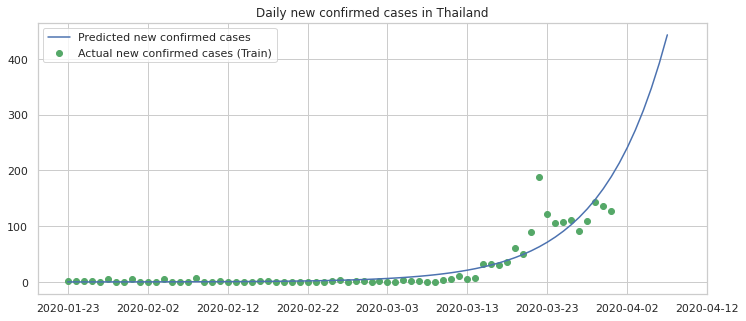

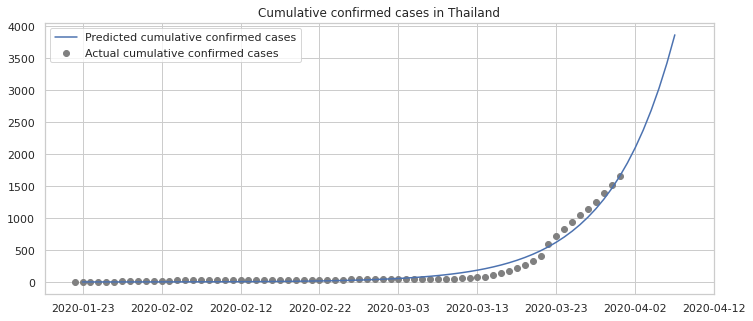

a_pred = 0.024742834919203094
b_pred = 0.12169968561708527
c_pred = -3.4673573942413194


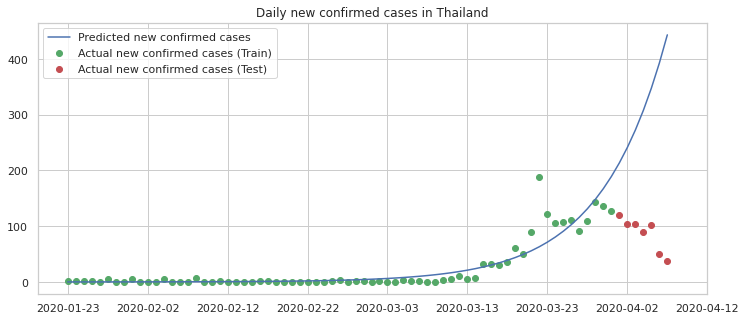

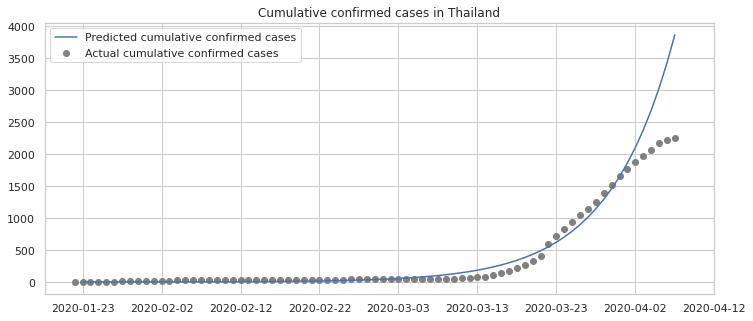

In [0]:
# exponential_model_mle_plot_frequency(country='Thailand',n_train=60,n_predict = 80,distribution = 'gaussian',initial_param = [1,0.01,1,11])
exponential_model_mle_plot_frequency(country='Thailand',n_train=69,n_predict = 76,distribution = 'poisson',initial_param = [1,0.01,1],show_test_set=False)
exponential_model_mle_plot_frequency(country='Thailand',n_train=69,n_predict = 76,distribution = 'poisson',initial_param = [1,0.01,1])

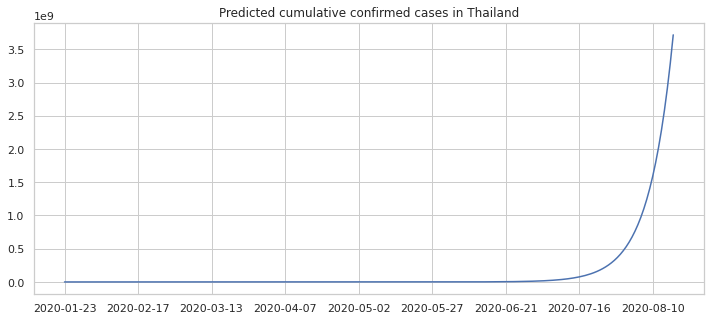

In [0]:
x= np.arange(1,209)
y = exponential_model(x,a = 0.024742834919203094,b=0.12169968561708527,c= -3.4673573942413194)
plt.figure(figsize=(12, 5))
plt.plot(x, y)
plt.xticks(np.arange(1,211,25), [(datetime.date(2020, 1, 23)+datetime.timedelta(days=i-1)) for i in range(1,211,25)])
plt.title("Predicted cumulative confirmed cases in " + country )
plt.show()

#### Italy

a_pred = 74.08185025335885
b_pred = 0.08906751409539687
c_pred = 7.037959032349438


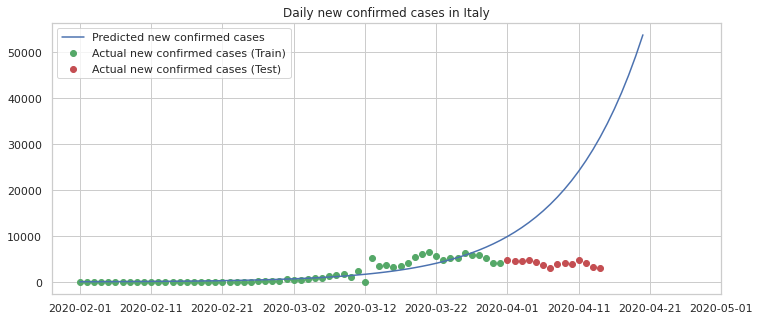

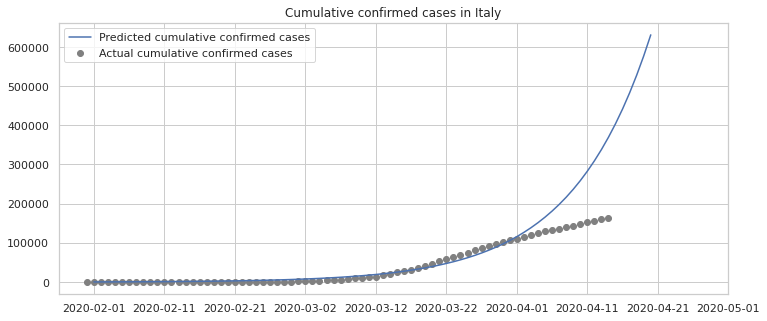

In [0]:
# exponential_model_mle_plot_frequency(country='Italy',n_train=60,n_predict = 80,distribution = 'gaussian',initial_param = [10,0.1,8,3])
exponential_model_mle_plot_frequency(country='Italy',n_train=60,n_predict = 80,distribution = 'poisson',initial_param = [1,-1,1])

#### South Korea

a_pred = 17.349955093489996
b_pred = 0.04101066805201942
c_pred = -15.122243482138238


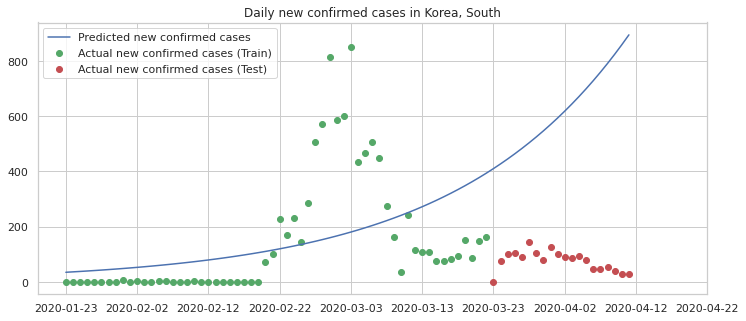

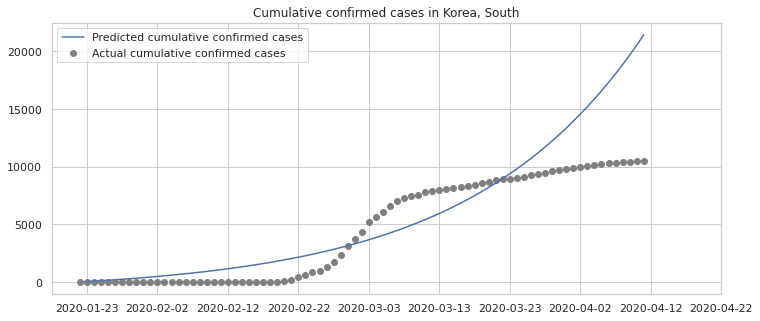

In [0]:
# exponential_model_mle_plot_frequency(country='Italy',n_train=60,n_predict = 80,distribution = 'gaussian',initial_param = [10,0.1,8,3])
exponential_model_mle_plot_frequency(country='Korea, South',n_train=60,n_predict = 80,distribution = 'poisson',initial_param = [1,-1,1])

#### Japan

a_pred = 1.593119130046944
b_pred = 0.06305876013570988
c_pred = 1.302964767061702


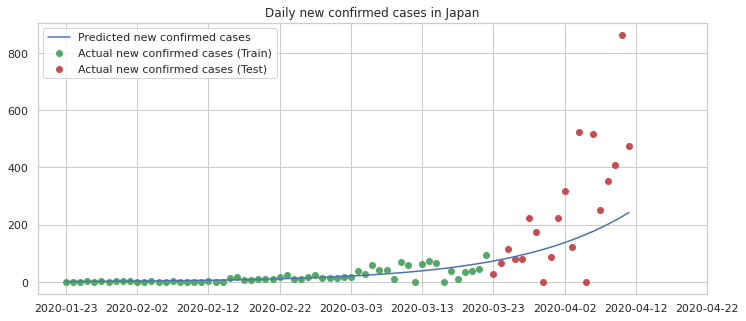

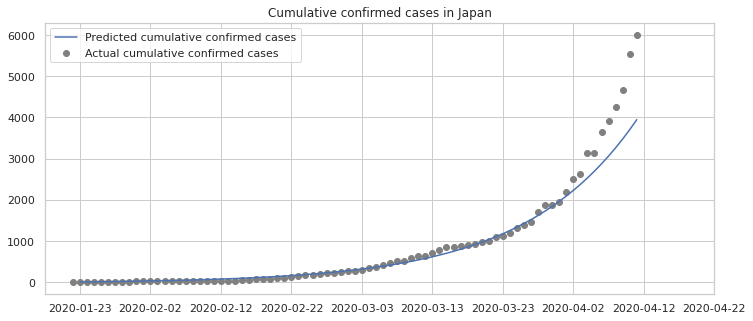

In [0]:
exponential_model_mle_plot_frequency(country='Japan',n_train=60,n_predict = 80,distribution = 'poisson',initial_param = [1,-1,1])

#### China

a_pred = 104.01950089491862
b_pred = 0.023729190307701577
c_pred = -116.6057146115206


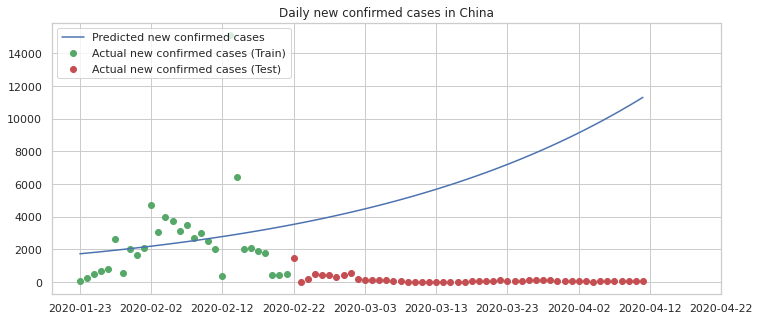

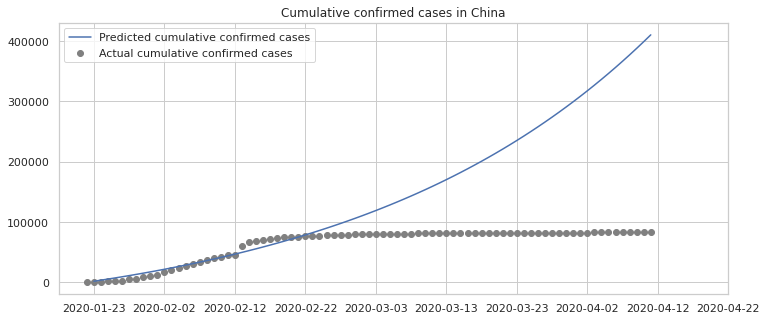

In [0]:
exponential_model_mle_plot_frequency(country='China',n_train=30,n_predict = 80,distribution = 'poisson',initial_param = [1,-1,1])

# Logistic growth

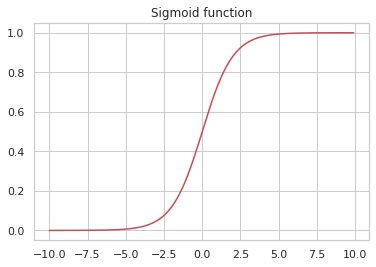

In [0]:
x = np.arange(-10,10,0.1)
y = 1/(1+np.exp(-x))
plt.plot(x,y,'r')
plt.title('Sigmoid function')
plt.show()

In [0]:
def logistic_model(x,a,b,c):
  return a/(1+np.exp(-b*(x-c)))

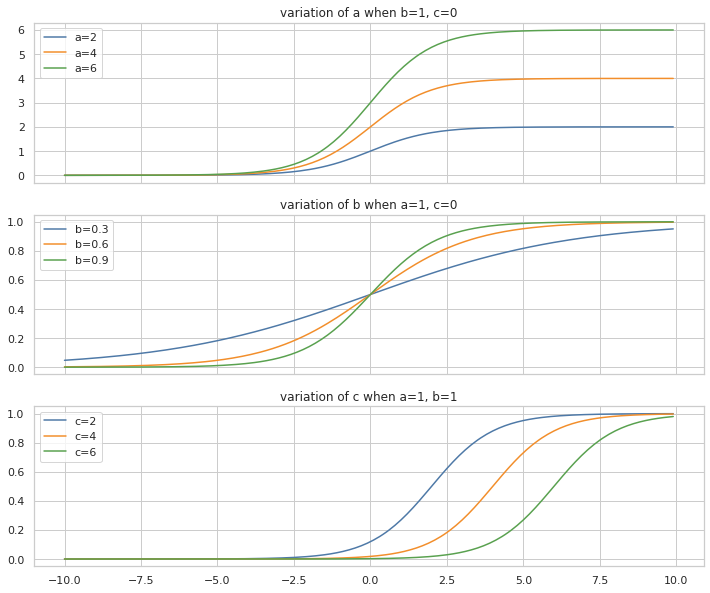

In [0]:
x = np.arange(-10,10,0.1)
a_var = np.arange(2,7,2)
b_var = np.arange(0.3,1,0.3)
c_var = np.arange(2,7,2)

#a defines the amplitude 
color_list = ['#4E79A7','#F28E2B','#59A14F']
i=0
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True,figsize=(12,10))
for a in a_var:
  y = logistic_model(x,a=a,b=1,c=0)
  ax1.plot(x,y,color_list[i],label = 'a='+str(a))
  i+=1
ax1.set_title('variation of a when b=1, c=0')
ax1.legend(loc="upper left")

#b determines growth rate
i=0
for b in b_var:
  y = logistic_model(x,a=1,b=b,c=0)
  ax2.plot(x,y,color_list[i],label = 'b='+str(round(b,1)))
  i+=1
ax2.set_title('variation of b when a=1, c=0')
ax2.legend(loc="upper left")

#c shifts curve left or right
i=0
for c in c_var:
  y = logistic_model(x,a=1,b=1,c=c)
  ax3.plot(x,y,color_list[i],label = 'c='+str(c))
  i += 1
ax3.set_title('variation of c when a=1, b=1')
ax3.legend(loc="upper left")
plt.show()

## Fit with least squared estimation

### Thailand

In [0]:
n = 100
country= 'Thailand'
thailand_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['day']<=n)&(case_report_by_counry_from_day1['Country']==country)]
x_train = thailand_cases['day'].to_numpy()
y_train = thailand_cases['Confirmed'].to_numpy()

In [0]:
logistic_fit = curve_fit(logistic_model,x_train,y_train,p0=[1500,0.5,20])
a_pred = logistic_fit[0][0]
b_pred = logistic_fit[0][1]
c_pred = logistic_fit[0][2]
y_pred = logistic_model(x_train,a=a_pred,b=b_pred,c=c_pred)

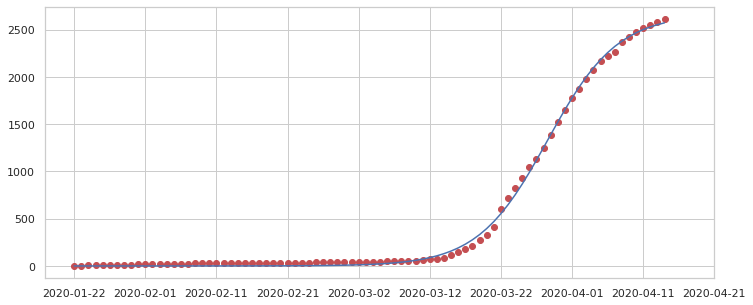

In [0]:
plt.figure(figsize=(12, 5))
plt.scatter(x_train,y_train,label="actual confirmed",color="r")
plt.plot(x_train, y_pred, label="Logistic model" )
plt.xticks(np.arange(1,len(x_train)+15,10), [(datetime.date(2020, 1, 21)+datetime.timedelta(days=i)) for i in range(1,len(x_train)+15,10)])
plt.show()

In [0]:
logistic_fit

(array([2.66160530e+03, 2.03581973e-01, 6.75733685e+01]),
 array([[ 4.45717722e+02, -6.06785109e-02,  2.34056320e+00],
        [-6.06785109e-02,  1.48401386e-05, -3.20395846e-04],
        [ 2.34056320e+00, -3.20395846e-04,  1.70742591e-02]]))

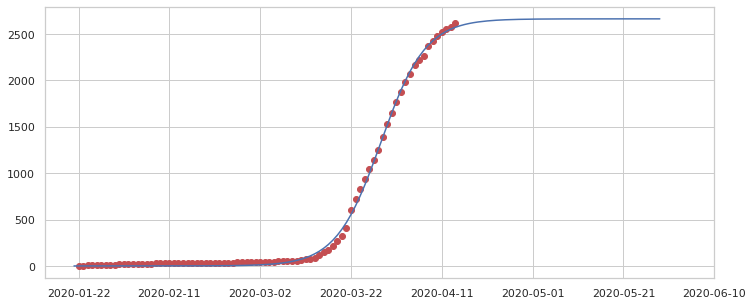

In [0]:
plt.figure(figsize=(12, 5))
x_test = np.arange(0,130)

y_pred = logistic_model(x_test,a_pred,b_pred,c_pred)
plt.scatter(x_train,y_train,label="actual confirmed",color="r")
plt.plot(x_test, y_pred, label="Logistic model" )
plt.xticks(np.arange(1,len(x_test)+15,20), [(datetime.date(2020, 1, 21)+datetime.timedelta(days=i)) for i in range(1,len(x_test)+15,20)])
plt.show()

## Write a function for reusability

In [0]:
def logistic_model_plot(country,n_train,n_predict):
  country_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['Country']==country)]
  x= country_cases['day'].to_numpy()
  y= country_cases['Confirmed'].to_numpy()
  min_date = np.min(country_cases['converted_date']).date()
  x_train = x[:n_train]
  y_train = y[:n_train]

  x_test = x[n_train:n_predict]
  y_test = y[n_train:n_predict]

  initial_param = [np.max(y_train),0.1,50] # init parameter with 1.5 times of current confirmed cases
  logistic_fit = curve_fit(logistic_model,x_train,y_train,p0=initial_param) #, maxfev=5000)
  a_pred = logistic_fit[0][0]
  b_pred = logistic_fit[0][1]
  c_pred = logistic_fit[0][2]
  print('a_pred = ' + str(a_pred))
  print('b_pred = ' + str(b_pred))
  print('c_pred = ' + str(c_pred))
  x_pred = np.arange(1,n_predict+1)
  y_pred = logistic_model(x_pred,a=a_pred,b=b_pred,c=c_pred)

  print('MAE (training set) = '+ str(mean_absolute_error(y_train, y_pred[:min(len(x_train),n_train)])))
  if len(y_test) > 0:
    print('MAE (test set) = '+ str(mean_absolute_error(y_test, y_pred[n_train:n_train+len(y_test)])))

  plt.figure(figsize=(12, 5))
  plt.scatter(x_train,y_train,label="actual confirmed",color="g")
  plt.scatter(x_test,y_test,label="actual confirmed",color="r")
  plt.plot(x_pred, y_pred)
  plt.xticks(np.arange(1,n_predict+15,10), [(min_date+datetime.timedelta(days=i-1)) for i in range(1,n_predict+15,10)])
  plt.title("Logistic model of " + country )
  plt.show()


#### Thailand

a_pred = 2181.4524990029863
b_pred = 0.2598356371507738
c_pred = 65.11564589026649
MAE (training set) = 26.139496245559897
MAE (test set) = 187.81244386069844


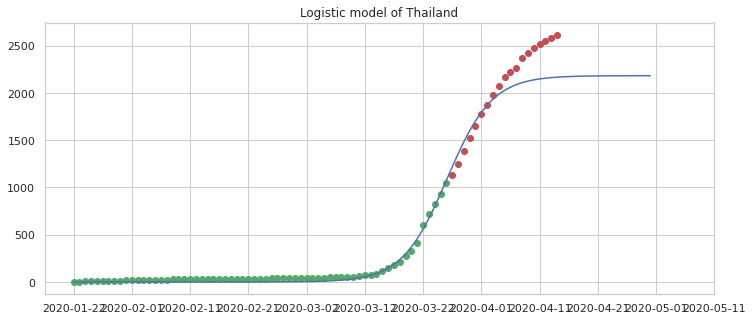

In [0]:
logistic_model_plot(country='Thailand',n_train=65,n_predict = 100)

#### China

a_pred = 80830.19531424815
b_pred = 0.22263144157276432
c_pred = 18.74160162630976
MAE (training set) = 1584.4409594135725
MAE (test set) = 909.3682290122279


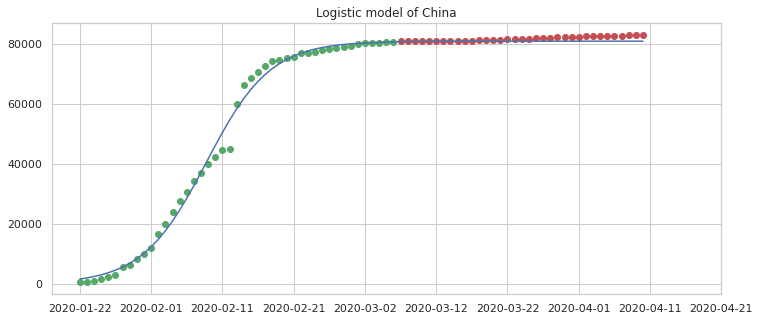

In [0]:
logistic_model_plot(country='China',n_train=45,n_predict = 80)

#### Italy

a_pred = 96457.36449568656
b_pred = 0.20633938393558574
c_pred = 50.38599970687205
MAE (training set) = 250.19294644757858
MAE (test set) = 20864.784585404926


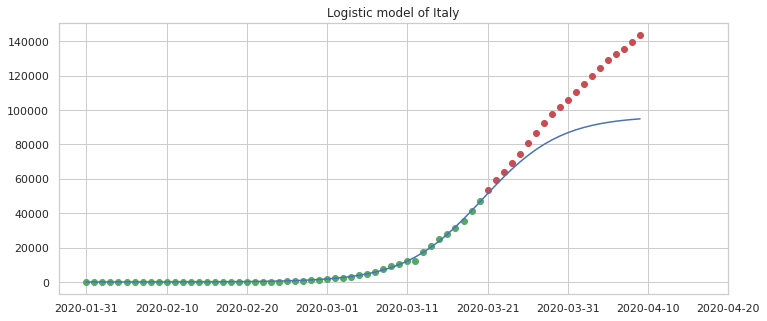

In [0]:
logistic_model_plot(country='Italy',n_train=50,n_predict = 70)

#### South Korea

a_pred = 8505.091991951196
b_pred = 0.36129894015612374
c_pred = 40.622683066253934
MAE (training set) = 30.424217988350808
MAE (test set) = 791.4057889434644


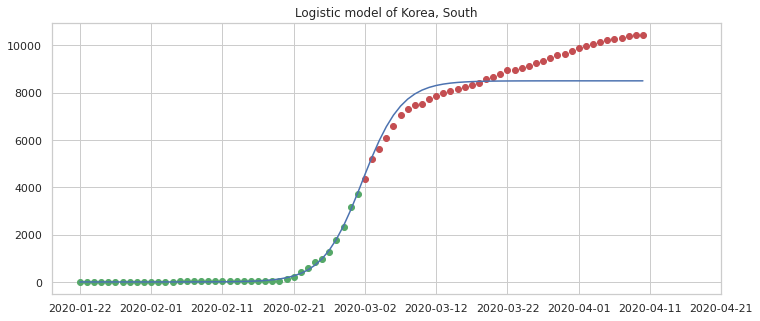

In [0]:
logistic_model_plot(country='Korea, South',n_train=40,n_predict = 80)

#### Japan

a_pred = 1369.6884678162587
b_pred = 0.12302258066416515
c_pred = 51.573488017763864
MAE (training set) = 9.94595269824366
MAE (test set) = 2018.7628099173762


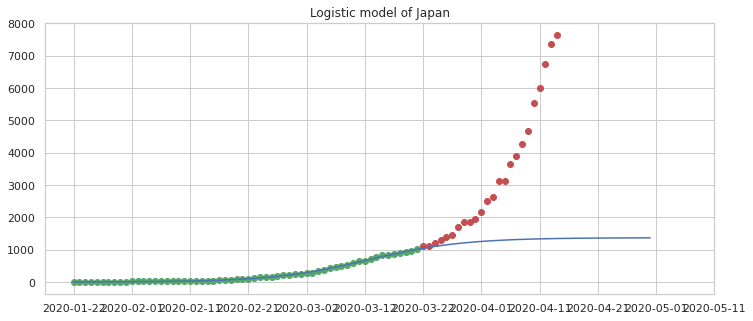

In [0]:
logistic_model_plot(country='Japan',n_train=60,n_predict = 100)

#### USA

a_pred = 179824.66170377107
b_pred = 0.3346402827462603
c_pred = 65.49066148341902
MAE (training set) = 214.73103277205195
MAE (test set) = 182421.42211452642


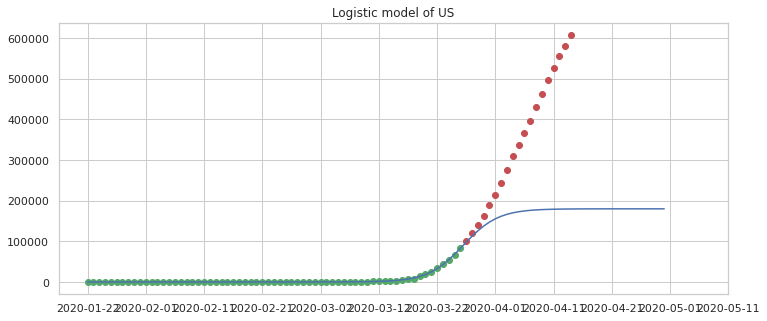

In [0]:
logistic_model_plot(country='US',n_train=65,n_predict = 100)

## Fit with maximum likelihood estimation 

### Logistic distribution function

In [0]:
def logistic_dist_model(x,a,b,c):
  return a*np.exp(-b*(x-c))/(1+np.exp(-b*(x-c)))**2

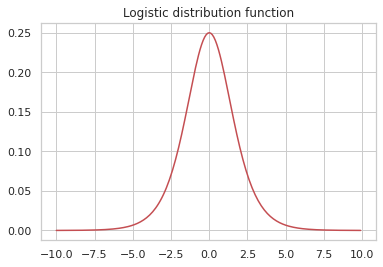

In [0]:
x = np.arange(-10,10,0.1)
y = np.exp(-x)/((1+np.exp(-x))*(1+np.exp(-x)))
plt.plot(x,y,'r')
plt.title('Logistic distribution function')
plt.show()

##### simulate new confirmed cases

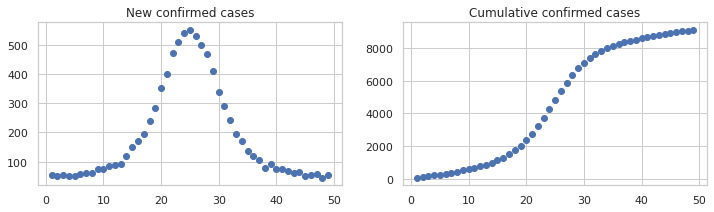

In [0]:

x= np.arange(1,50)
dif = np.random.poisson(50,len(x))
y = logistic_dist_model(x,2000,0.3,25) + dif
y_accum = np.cumsum(y)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,3))
ax1.scatter(x,y)
ax1.set_title('New confirmed cases')
ax2.scatter(x,y_accum)
ax2.set_title('Cumulative confirmed cases')
plt.show()


In [0]:
x = np.arange(-10,10,0.1)
a_var = np.arange(1,4,1)
b_var = np.arange(0.2,1.1,0.4)
c_var = np.arange(2,7,2)

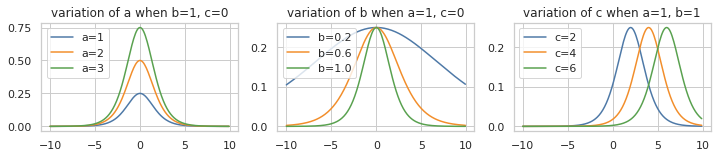

In [0]:
#a determines the amplitude 
color_list = ['#4E79A7','#F28E2B','#59A14F']
i=0
fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharex=True,figsize=(12,2))
for a in a_var:
  y = logistic_dist_model(x,a=a,b=1,c=0)
  ax1.plot(x,y,color_list[i],label = 'a='+str(a))
  i+=1
ax1.set_title('variation of a when b=1, c=0')
ax1.legend(loc="upper left")

#b determines growth rate
i=0
for b in b_var:
  y = logistic_dist_model(x,a=1,b=b,c=0)
  ax2.plot(x,y,color_list[i],label = 'b='+str(b)[:3])
  i+=1
ax2.set_title('variation of b when a=1, c=0')
ax2.legend(loc="upper left")

#c shifts curve left or right
i=0
for c in c_var:
  y = logistic_dist_model(x,a=1,b=1,c=c)
  ax3.plot(x,y,color_list[i],label = 'c='+str(c))
  i += 1
ax3.set_title('variation of c when a=1, b=1')
ax3.legend(loc="upper left")
plt.show()

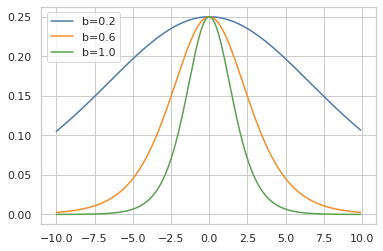

In [0]:
#b determines growth rate
i=0
for b in b_var:
  y = logistic_dist_model(x,a=1,b=b,c=0)
  plt.plot(x,y,color_list[i],label = 'b='+str(round(b,1)))
  i+=1
plt.legend(loc="upper left")
plt.show()

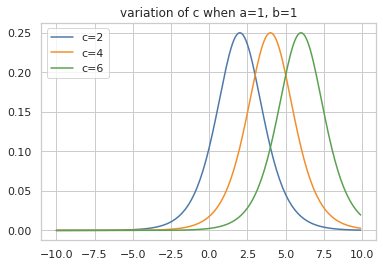

In [0]:
#c shifts curve left or right
i=0
for c in c_var:
  y = logistic_dist_model(x,a=1,b=1,c=c)
  plt.plot(x,y,color_list[i],label = 'c='+str(c))
  i += 1
plt.title('variation of c when a=1, b=1')
plt.legend(loc="upper left")
plt.show()

### Write a function

In [0]:
def logistic_model_mle_plot_frequency(country,n_train,n_predict,initial_param=[1,1,-1],distribution='gaussian',show_test_set = True):

  new_case_by_selected_country = new_case_report_by_country[new_case_report_by_country['Country']==country]
  x = new_case_by_selected_country['day'].to_numpy()
  y= new_case_by_selected_country['new_confirmed'].to_numpy()
  x_train = x[:n_train]
  y_train = y[:n_train]
  min_date = np.min(new_case_by_selected_country['converted_date']).date()
  x_test = x[n_train:n_predict]
  y_test = y[n_train:n_predict]

  country_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['Country']==country)]
  x= country_cases['day'].to_numpy()
  y= country_cases['Confirmed'].to_numpy()
  x_accum = x[:n_predict]

  x_accum_train = x[:n_train+1]
  y_accum_train = y[:n_train+1]
  x_accum_test = x[n_train+1:n_predict+1]
  y_accum_test = y[n_train+1:n_predict+1]

  def sum_negative_log_likelihood_gaussian(params):
    a,b,c,sd = params
    y = logistic_dist_model(x_train,a,b,c)
    neg_log_likelihood = -np.sum( stats.norm.logpdf(y_train, loc=y, scale=sd ) )
    return (neg_log_likelihood)

  def sum_negative_log_likelihood_poisson(params):
    a,b,c = params
    y = logistic_dist_model(x_train,a,b,c)
    neg_log_likelihood = -np.sum(stats.poisson.logpmf(y_train, mu=y))
    return (neg_log_likelihood)
  if distribution == 'gaussian':
    exp_fit = minimize(sum_negative_log_likelihood_gaussian, initial_param, method='Nelder-Mead')
  else:
    exp_fit = minimize(sum_negative_log_likelihood_poisson, initial_param, method='Nelder-Mead')
    
  a_pred = exp_fit.x[0]
  b_pred = exp_fit.x[1]
  c_pred = exp_fit.x[2]
  print('a_pred = ' + str(a_pred))
  print('b_pred = ' + str(b_pred))
  print('c_pred = ' + str(c_pred))
  x_pred = np.arange(2,n_predict+2)
  y_pred = logistic_dist_model(x_pred,a=a_pred,b=b_pred,c=c_pred)
  y_pred_accum = y_pred.copy()
  y_pred_accum[0] = x_accum_train[0]+ y_pred_accum[0]
  y_pred_accum = np.cumsum(y_pred_accum)

  plt.figure(figsize=(12, 5))
  plt.scatter(x_train,y_train,label="Actual new confirmed cases (Train)",color="g")
  if show_test_set:
    plt.scatter(x_test,y_test,label="Actual new confirmed cases (Test)",color="r")
  plt.plot(x_pred, y_pred,label="Predicted new confirmed cases")
  plt.xticks(np.arange(2,n_predict+15,15), [(min_date+datetime.timedelta(days=i)) for i in range(0,n_predict+15,15)])
  plt.title("Daily new confirmed cases in " + country )
  plt.legend(loc="upper left")
  plt.show()

  plt.figure(figsize=(12, 5))
  plt.scatter(x_accum_train,y_accum_train,label="Actual cumulative confirmed cases",color="grey")

  if show_test_set:
    plt.scatter(x_accum_test,y_accum_test,color="grey")
  plt.plot(x_pred, y_pred_accum, label ="Predicted cumulative confirmed cases" )
  plt.xticks(np.arange(2,n_predict+15,15), [(min_date+datetime.timedelta(days=i)) for i in range(0,n_predict+15,15)])
  plt.title("Cumulative confirmed cases in " + country )
  plt.legend(loc="upper left")
  plt.show()

a_pred = 582.7722291101516
b_pred = 0.16824517597402228
c_pred = 71.0690009934489


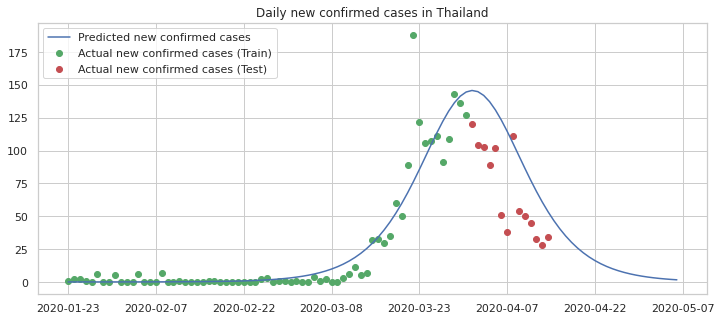

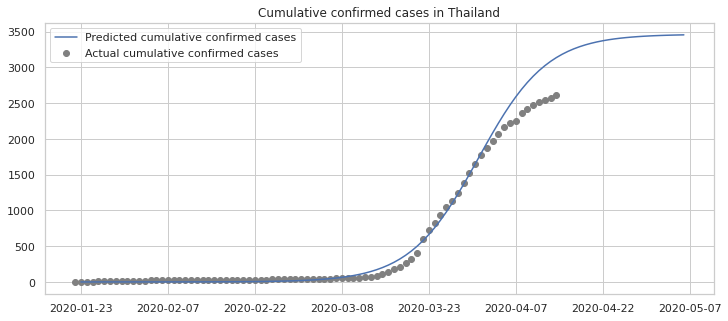

In [0]:
# logistic_model_mle_plot_frequency(country='Thailand',n_train=69,n_predict = 100,initial_param = [150, 0.01,70,30],distribution='gaussian')
logistic_model_mle_plot_frequency(country='Thailand',n_train=69,n_predict = 105,initial_param = [150, 0.01,70],distribution='poisson')

a_pred = 24387.73459420886
b_pred = 0.18752903050179
c_pred = 53.6496343530716


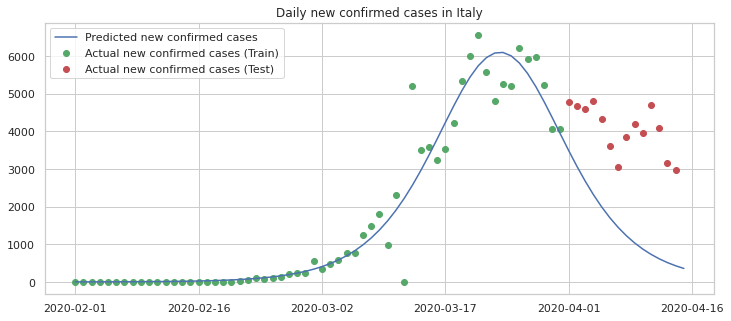

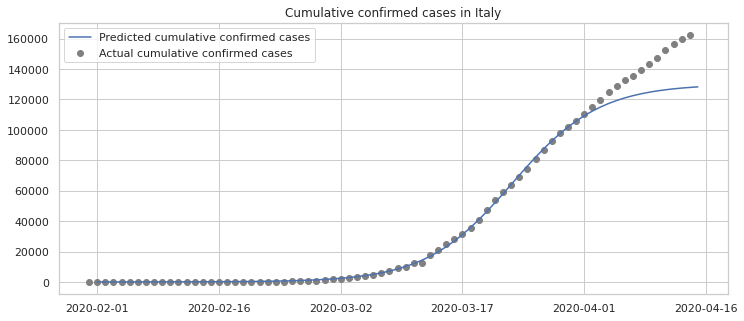

In [0]:
# logistic_model_mle_plot_frequency(country='Italy',n_train=60,n_predict = 75,initial_param = [7000, 0.1,50,3],distribution='gaussian')
logistic_model_mle_plot_frequency(country='Italy',n_train=60,n_predict = 75,initial_param = [7000, 0.1,50],distribution='poisson')

a_pred = -9563103.817638459
b_pred = -115.01302625253854
c_pred = 9464.817247966426


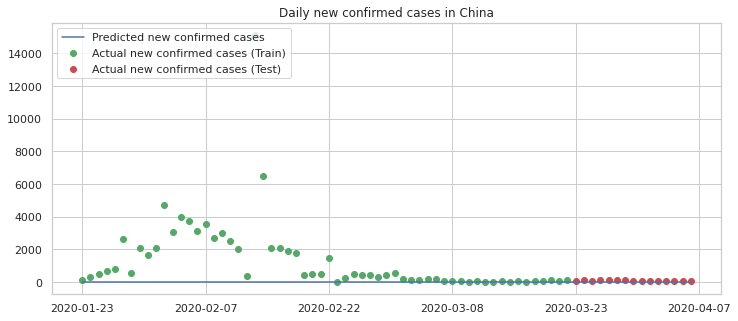

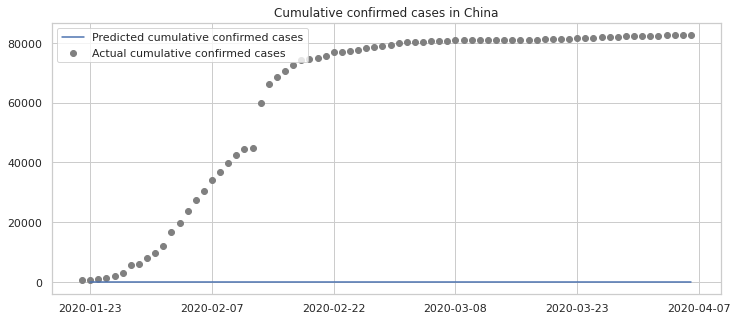

a_pred = 17220.829425477852
b_pred = 0.20747150022820265
c_pred = 19.081823576723828


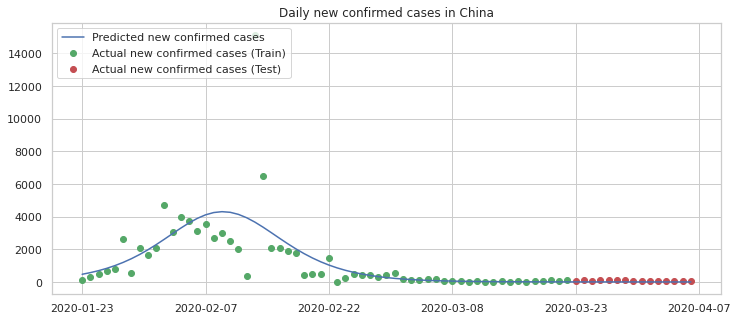

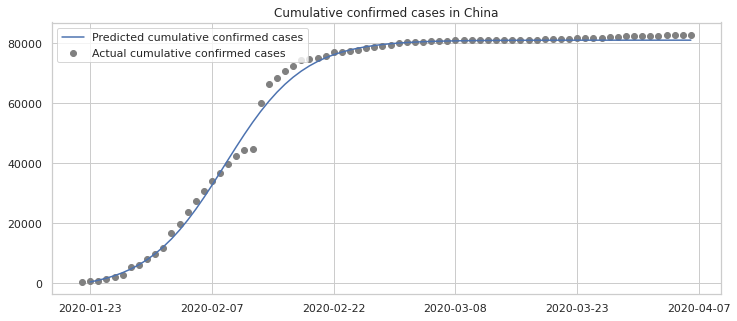

In [0]:
logistic_model_mle_plot_frequency(country='China',n_train=60,n_predict = 75,initial_param = [18000, 0.2,15,3],distribution='gaussian')
logistic_model_mle_plot_frequency(country='China',n_train=60,n_predict = 75,initial_param = [20000, 0.1,20],distribution='poisson')

#### Thailand

a_pred = 582.7722374394557
b_pred = 0.16824518028641205
c_pred = 71.0690007148602


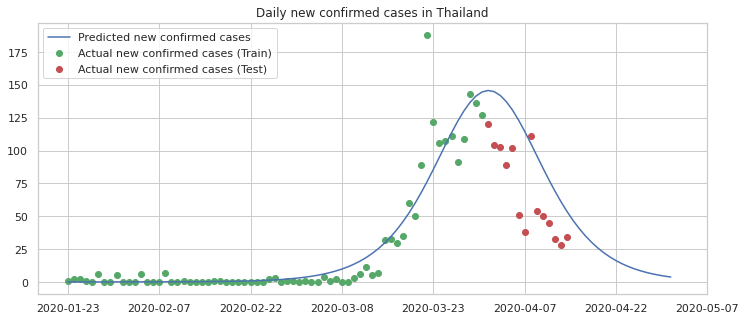

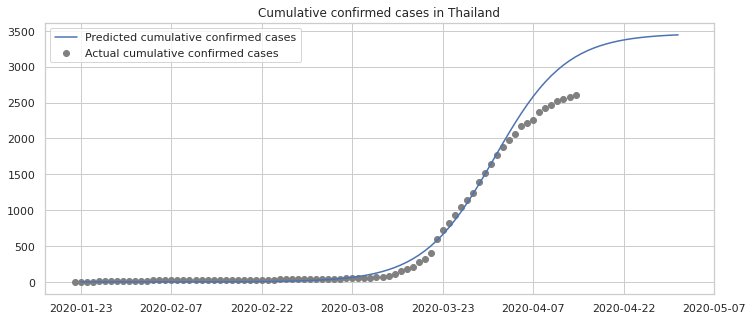

In [0]:
# logistic_model_mle_plot_frequency(country='Thailand',n_train=69,n_predict = 76,initial_param = [2000, 0.2,65,100],distribution='gaussian')
logistic_model_mle_plot_frequency(country='Thailand',n_train=69,n_predict = 100,initial_param = [2181, 0.25,65],distribution='poisson')

a_pred = 504.6922898030832
b_pred = 0.18336812456501567
c_pred = 68.60235198086161


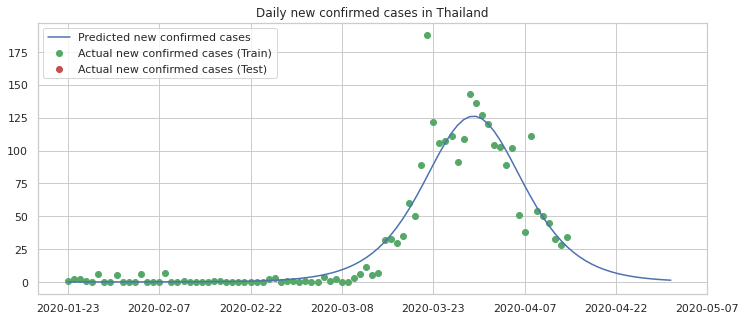

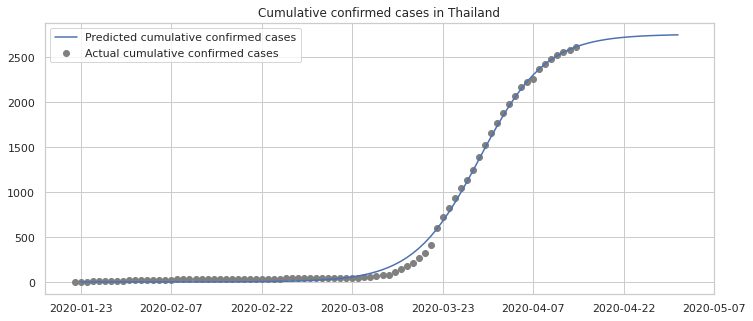

In [0]:
# logistic_model_mle_plot_frequency(country='Thailand',n_train=69,n_predict = 76,initial_param = [2000, 0.2,65,100],distribution='gaussian')
logistic_model_mle_plot_frequency(country='Thailand',n_train=100,n_predict = 100,initial_param = [2181, 0.25,65],distribution='poisson')

#### Italy

a_pred = 37370.43436022221
b_pred = 0.1582978178575596
c_pred = 59.04694735859172


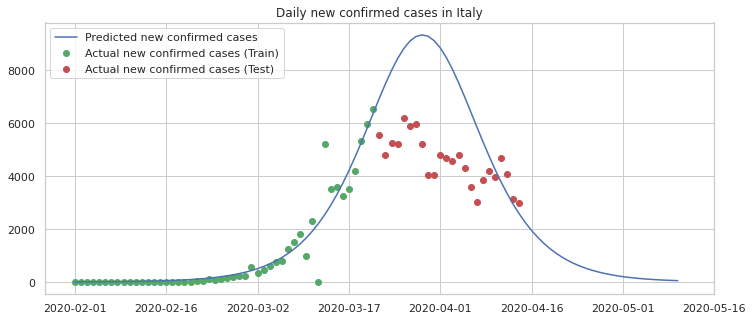

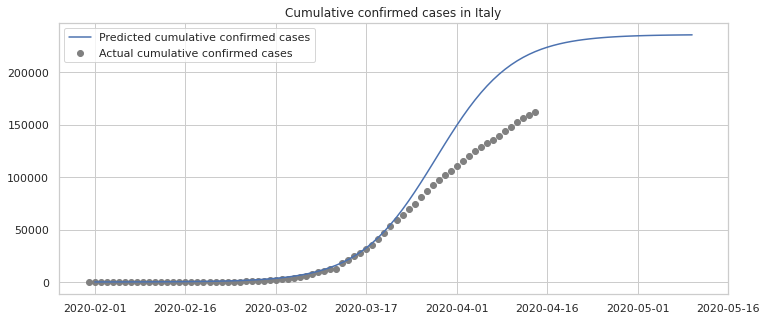

a_pred = 24387.73531687571
b_pred = 0.18752903489410366
c_pred = 53.64963429473097


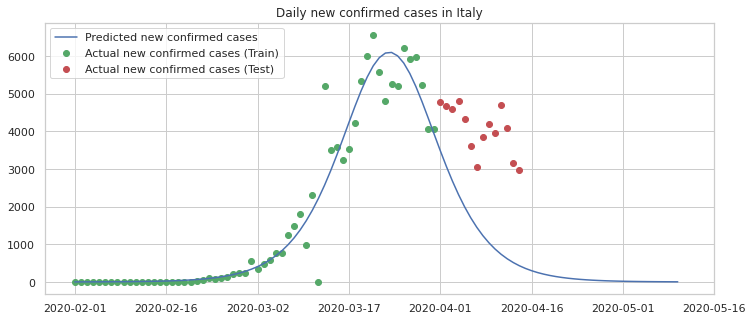

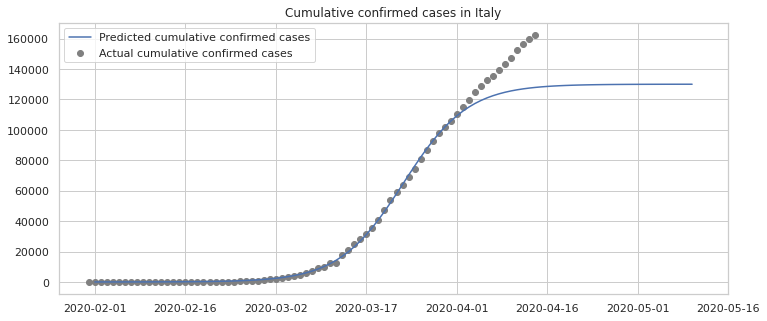

In [0]:
logistic_model_mle_plot_frequency(country='Italy',n_train=50,n_predict = 100,initial_param = [120000, 0.2,65,100],distribution='gaussian')
logistic_model_mle_plot_frequency(country='Italy',n_train=60,n_predict = 100,initial_param = [120000, 0.2,100],distribution='poisson')

#### China

a_pred = 16173.71425378458
b_pred = -0.19128698349002132
c_pred = 19.099476393587288


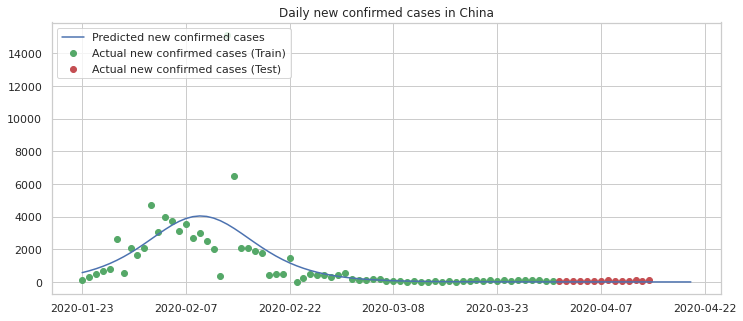

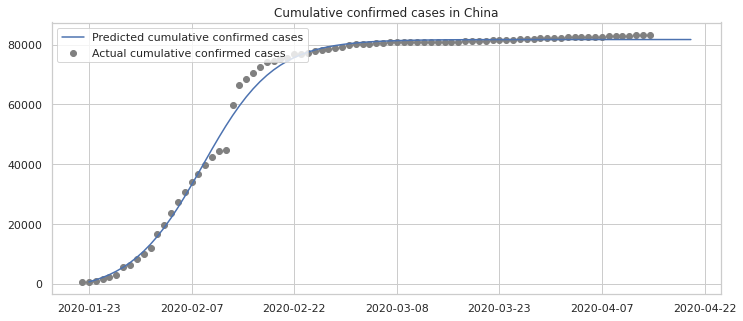

In [0]:
# logistic_model_mle_plot_frequency(country='China',n_train=60,n_predict = 100,initial_param = [120000, 0.2,65,100],distribution='gaussian')
logistic_model_mle_plot_frequency(country='China',n_train=69,n_predict = 89,initial_param = [1000, 0.2,100],distribution='poisson')

a_pred = 7874.9055388562965
b_pred = 0.4763546142588255
c_pred = 9.669465005069434


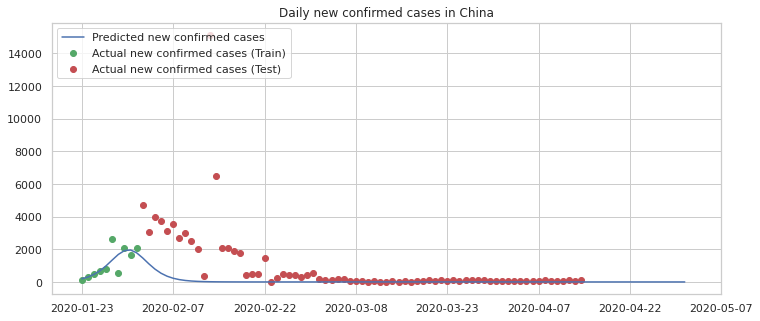

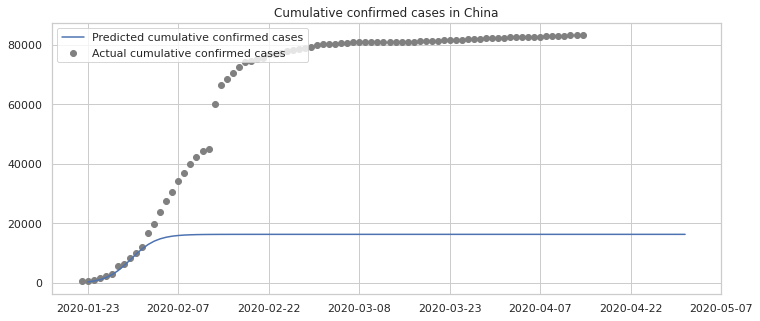

In [0]:
logistic_model_mle_plot_frequency(country='China',n_train=10,n_predict = 100,initial_param = [1000, 0.2,100],distribution='poisson')

a_pred = 14866.834148096717
b_pred = -0.3352179842305209
c_pred = 14.094567207419985


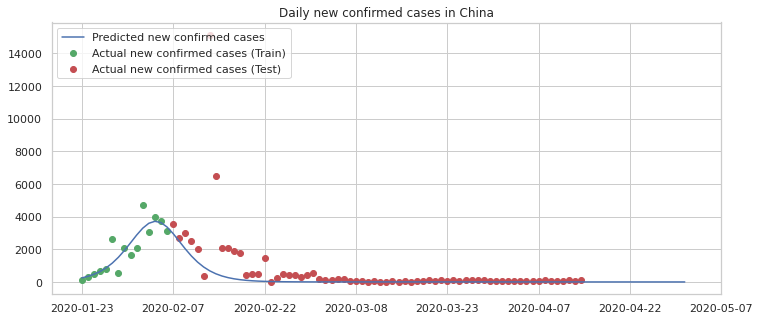

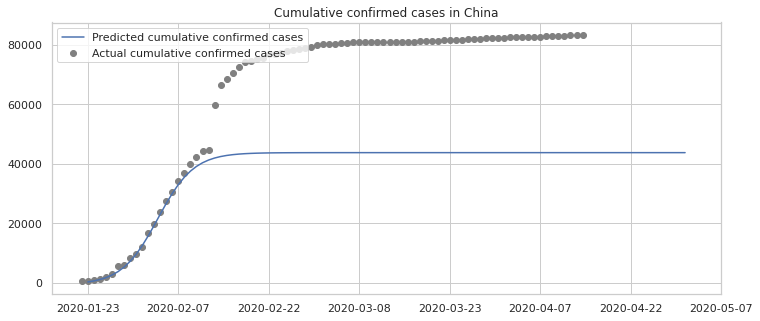

In [0]:
logistic_model_mle_plot_frequency(country='China',n_train=15,n_predict = 100,initial_param = [1000, 0.2,100],distribution='poisson')

a_pred = 15263.801149795669
b_pred = -0.29765178809723086
c_pred = 15.05772648833829


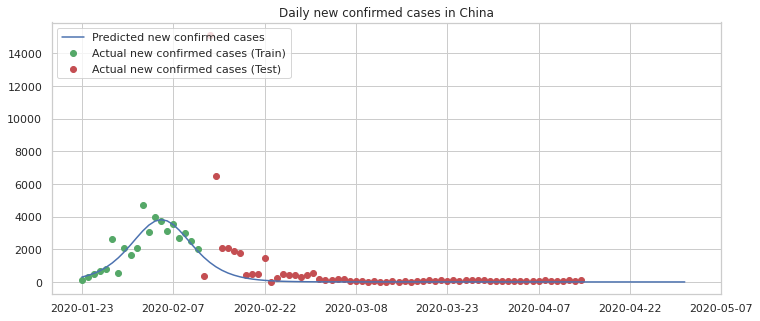

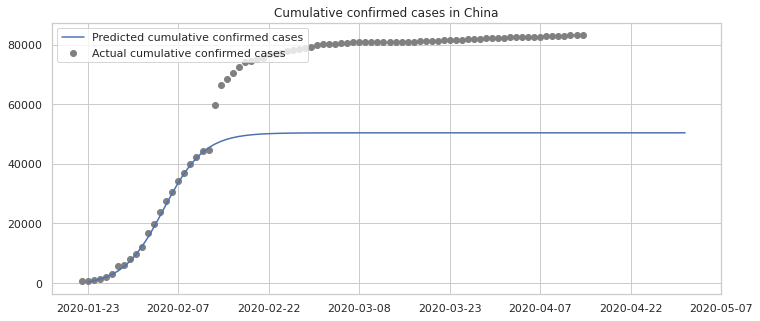

In [0]:
logistic_model_mle_plot_frequency(country='China',n_train=20,n_predict = 100,initial_param = [1000, 0.2,100],distribution='poisson')

a_pred = 18134.47473882523
b_pred = -0.17483921309556705
c_pred = 21.55745210197319


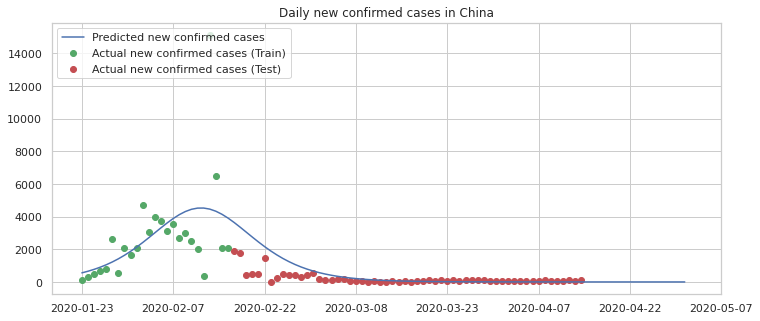

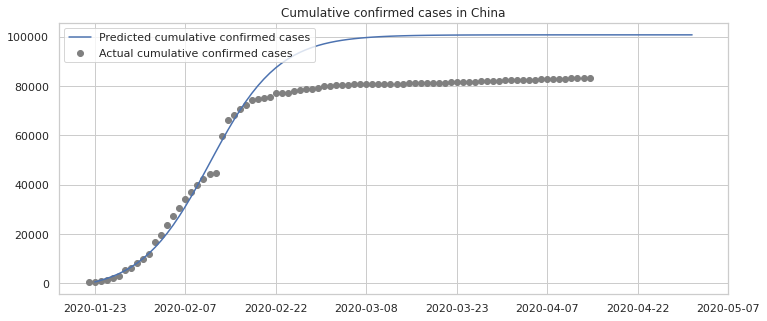

In [0]:
logistic_model_mle_plot_frequency(country='China',n_train=25,n_predict = 100,initial_param = [1000, 0.2,100],distribution='poisson')

a_pred = 18179.78142844864
b_pred = -0.2238469602871816
c_pred = 18.96234381088344


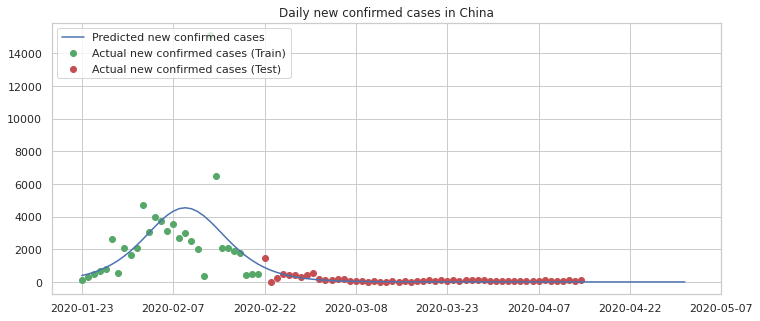

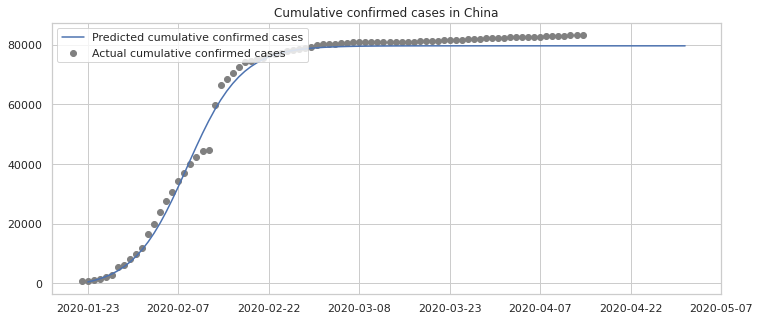

In [0]:
logistic_model_mle_plot_frequency(country='China',n_train=30,n_predict = 100,initial_param = [1000, 0.2,100],distribution='poisson')

a_pred = 17854.947231509403
b_pred = -0.21786925028220416
c_pred = 19.02678025777282


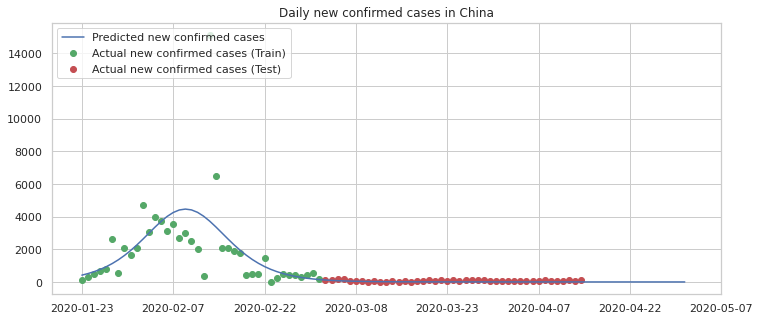

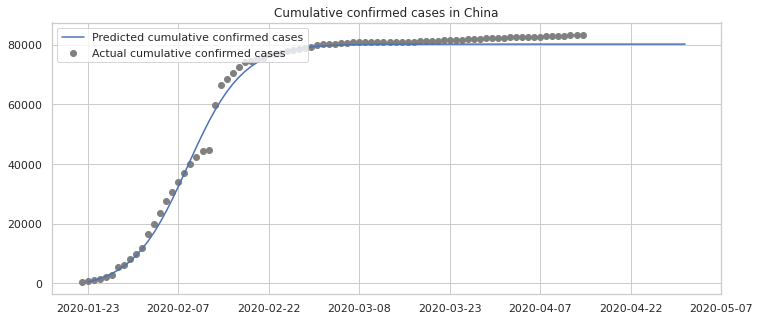

In [0]:
logistic_model_mle_plot_frequency(country='China',n_train=40,n_predict = 100,initial_param = [1000, 0.2,100],distribution='poisson')

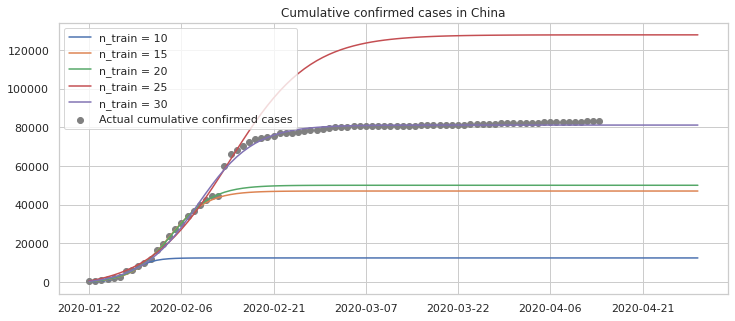

In [0]:
n_train_list = [10,15,20,25,30]
a_list = [7274.028677,15377.78179,15277.9054,20054.50918,18027.54662]
b_list= [-0.576534526,-0.322887188,-0.301139097,-0.152762148,0.218193339]
c_list = [8.610592873,14.51076607,14.97875059,24.27003804,19.12959156]
n_predict= 101
country = 'China'
country_cases = case_report_by_counry_from_day1[(case_report_by_counry_from_day1['Country']==country)]
x= country_cases['day'].to_numpy()
y= country_cases['Confirmed'].to_numpy()
min_date = np.min(country_cases['converted_date']).date()
plt.figure(figsize=(12, 5))
plt.scatter(x,y,label="Actual cumulative confirmed cases",color="grey")

for i in range(len(n_train_list)):
  n_train = n_train_list[i]
  a = a_list[i]
  b = b_list[i]
  c = c_list[i]
  x_pred = np.arange(1,n_predict)
  y_pred = logistic_dist_model(x_pred,a=a,b=b,c=c)
  y_pred_accum = np.cumsum(y_pred)
  plt.plot(x_pred, y_pred_accum, label ="n_train = " + str(n_train) )
  plt.xticks(np.arange(1,len(x)+15,15), [(min_date+datetime.timedelta(days=i-1)) for i in range(1,len(x)+15,15)])
  plt.title("Cumulative confirmed cases in " + country )
  plt.legend(loc="upper left")
plt.show()

#### Japan

a_pred = 26478.71890396165
b_pred = 0.05780514876726425
c_pred = 164.22975178230928


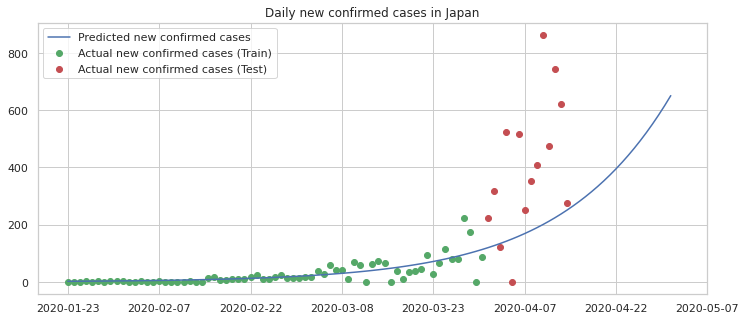

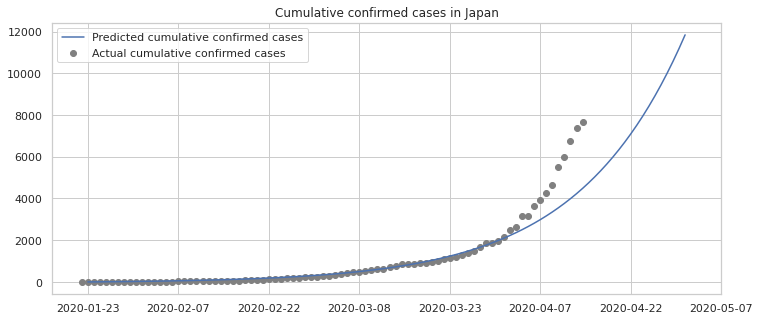

a_pred = 510.4831544270646
b_pred = 0.07605944464736754
c_pred = 82.08864922770007


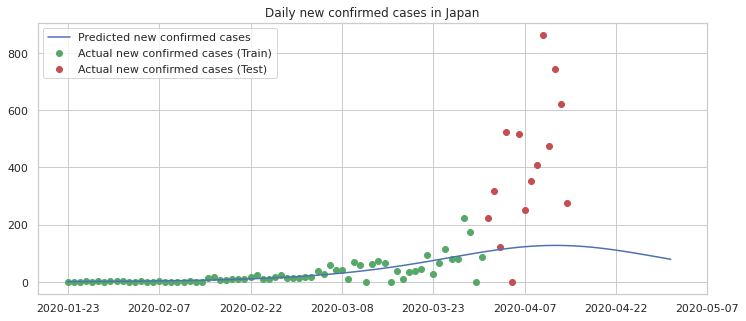

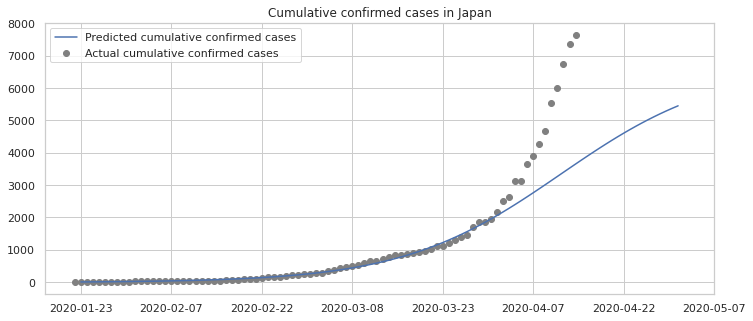

In [0]:
logistic_model_mle_plot_frequency(country='Japan',n_train=69,n_predict = 100,initial_param = [8000, 0.2,65,100],distribution='gaussian')
logistic_model_mle_plot_frequency(country='Japan',n_train=69,n_predict = 100,initial_param = [8000, 0.2,100],distribution='poisson')

#### South Korea

a_pred = 2293.099636881627
b_pred = 0.2540257716775378
c_pred = 42.222366345376734


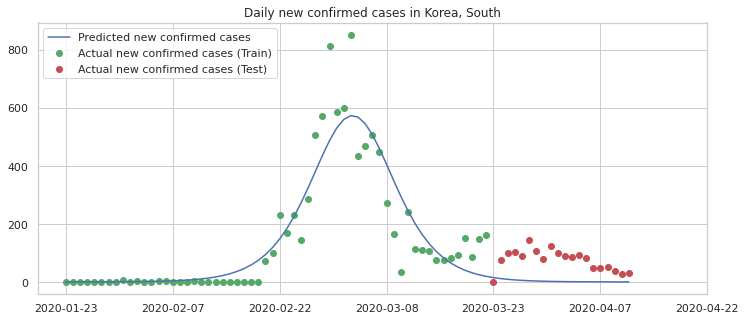

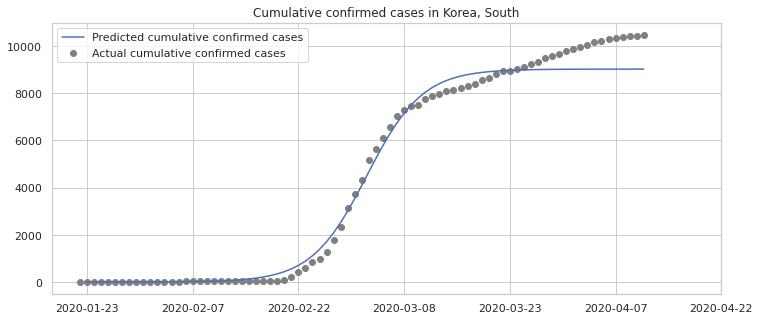

In [0]:
logistic_model_mle_plot_frequency(country='Korea, South',n_train=60,n_predict = 80,initial_param = [8000, 0.2,100],distribution='poisson')